# Determinant QMC data visualization

## Are you testing or making plots?

In [101]:
SAVEPLOTS = True

## Load simulation data

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
cwd = os.getcwd()
import seaborn as sns
sns.set()
sns.set_palette("Blues_r")
sns.set_style("white")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

NSITES = 60
dt = 0.0625
beta = 15.
L = 240
t = 1.
U = 4.
mu = 0.
totalMCSweeps = 5000
freq = 4
intsize = 60
geom = 1
ny = 0

mainDir = ('../data/' + str(NSITES) + \
             'sites_L=' + str(L) + \
             '_beta=' + str(beta) + \
             '_dt_' + str(dt) + '_t_' + \
             str(t) + '_U_'+ str(U) + '_mu_' + str(mu))

simDir = (mainDir + '/data-to-reproduce/' + \
              'totalMCSweeps_' + str(totalMCSweeps) + \
              '_freq_' + str(freq) + '_intsize_' + str(intsize) + \
              '_geom_' + str(geom) + '_ny_' + str(ny) )

plotDir = (mainDir + '/plots/' + \
              'totalMCSweeps_' + str(totalMCSweeps) + \
              '_freq_' + str(freq) + '_intsize_' + str(intsize) + \
              '_geom_' + str(geom) + '_ny_' + str(ny) )

# Load weights to plot

weights = np.loadtxt(simDir + '/Log-weights.txt')

WL = weights.size

latSweeps = np.arange(WL) + 1

# Metropolis Sampling convergence

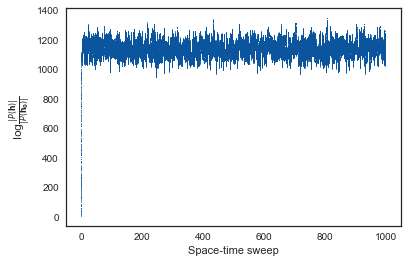

In [103]:
plt.scatter(latSweeps / L, weights, s = 0.3) #show time in space-time sweeps
plt.xlabel(r"Space-time sweep")
plt.ylabel(r'$\log \frac{| P(\mathbf{h}) | }{ | P(\mathbf{h_0}) | } $')
if SAVEPLOTS == True:
    plt.savefig(plotDir + '/Log-weights.png', dpi = 600)

# Sign problem

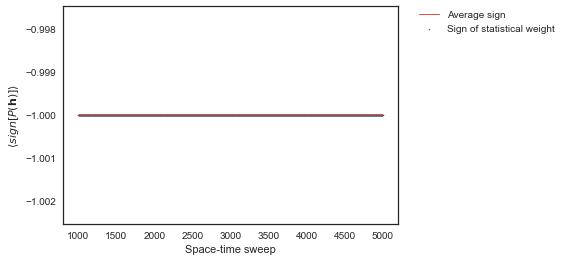

In [105]:
W = 1000
sweeps = np.arange(0, totalMCSweeps - W) + 1 + W
signs = np.loadtxt(simDir + '/Local-av-sign.txt')
avSign = np.mean(signs) * np.ones(len(sweeps))

fig = plt.figure(1)
ax = fig.add_subplot(111)
plt.xlabel(r'Space-time sweep')
plt.ylabel(r'$\left\langle sign [P(\mathbf{h})] \right\rangle$ ')
ax.scatter(sweeps, signs, s = 1, color = "#34495e", label = 'Sign of statistical weight')
ax.plot(sweeps, avSign, linewidth = 1, color = "#e74c3c", label = 'Average sign')
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
if SAVEPLOTS == True:
    plt.savefig(plotDir + '/Local-av-sign.png', dpi = 600,
                bbox_extra_artists=(lgd,), bbox_inches='tight')

# Magnetic structure factor $S(\mathbf q) = \frac{1}{N} \sum_{i, j} e^{i \mathbf q \cdot  (\mathbf i - \mathbf j)} \left\langle \mathbf S_{\mathbf i} \cdot \mathbf S_{\mathbf j} \right\rangle $

## Auto-correlation time in the measurement of the correlation function

In [109]:
magCorr = np.loadtxt(simDir + '/EqTimeSzCorrelations.txt')

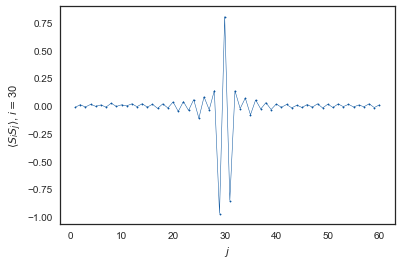

In [110]:
plt.scatter( NSITES - np.arange(NSITES), magCorr[int(NSITES/2), :], s = 2, marker = 'o')
plt.plot( NSITES - np.arange(NSITES), magCorr[int(NSITES/2), :], linewidth = 0.5)
plt.xlabel(r'$j$')
plt.ylabel(r'$\left\langle S_i S_j \right\rangle$, $i = $' + str(int(NSITES/2)))
if SAVEPLOTS == True:
    plt.savefig(plotDir + '/magCorr.png', dpi = 600)

## Fourier transform to obtain the structure factor    

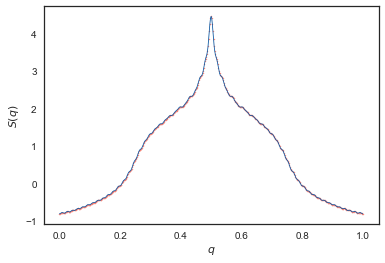

In [111]:
n_qs = 500
qMax = 2*np.pi
qs = np.arange(0, qMax + qMax/n_qs, qMax/n_qs)
S = np.zeros(n_qs+1)
dist = 0

for idx, q in enumerate(qs):
    for x in range(NSITES):
        for y in range(NSITES):
            if ( x - y ) > NSITES/2:
                dist = NSITES - abs(x - y)
            else:
                dist = abs(x - y)
            S[idx] += np.cos( dist * q ) * magCorr[x, y]

S /=  NSITES # factor of 16 comes from 1/2 spins and overcounting

plt.scatter(qs/2/np.pi, S, s = 1.2, color = 'salmon')
plt.plot(qs/2/np.pi, S, linewidth = 0.8)
plt.xlabel(r'$q$')
plt.ylabel(r'$S(q)$')
if SAVEPLOTS == True:
    plt.savefig(plotDir + '/S(q).png', dpi = 600)

### It has a maximum at $q = \pi$ signaling quasi-AF order

In [112]:
qs[np.argmax(S)]

3.1415926535897931

## Compare with the results for 60 sites obtained by Yi et al.

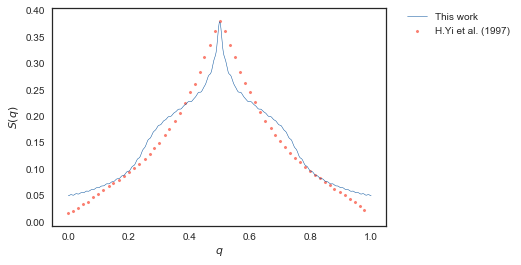

In [117]:
s_compare = np.loadtxt("../data/Yi1997/s_compare.csv")
fig = plt.figure(0)
ax = fig.add_subplot(111)
plt.xlabel(r'$q$')
plt.ylabel(r'$S(q)$')
ax.scatter(s_compare[:, 0], s_compare[:, 1], s = 4, color = 'salmon', marker = 'x', label = 'H.Yi et al. (1997)')
ax.plot(qs/2/np.pi, S/16+0.1, linewidth = 0.5, label = 'This work')
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
if SAVEPLOTS == True:
    plt.savefig(plotDir + '/s_compare.png', dpi = 600)

# Magnetic susceptibility $\chi(\mathbf q) = \frac{1}{N} \sum_{i, j} e^{i \mathbf q \cdot  (\mathbf i - \mathbf j)} \int_0^\beta \left\langle \mathbf S_{\mathbf i}(\tau) \cdot \mathbf S_{\mathbf j}(0) \right\rangle d\tau $

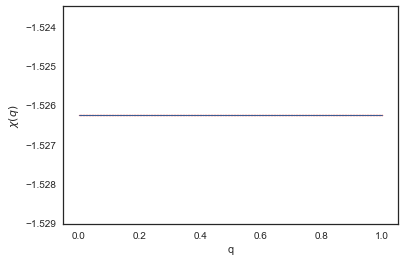

In [133]:
UneqMagCorrMeas = np.loadtxt(simDir + '/UneqTimeSzCorrelations.txt', skiprows = 1)

UneqMagCorr = np.zeros((NSITES, NSITES))

# Average unequal time spin-spin correlation function

for m in range(totalMCSweeps - W):
    if m % 100 == 0:
        UneqMagCorr += ( UneqMagCorrMeas[(m + W)*NSITES:(m + W + 1)*NSITES]\
                        - UneqMagCorr ) / ( ( m + 1) / 100 )
    
# Compute structure factor    
    
n_qs = 500
qMax = 2*np.pi
threshold = 0
qs = np.arange(threshold * qMax/n_qs, qMax - (threshold - 1) * qMax/n_qs , qMax/n_qs)
MagSus = np.zeros(n_qs - 2 * threshold + 1)

for idx, q in enumerate(qs):
    for x in range(int(np.sqrt(NSITES))):
        for y in range(int(np.sqrt(NSITES))):
            if ( x - y ) > NSITES/2:
                dist = NSITES - (x - y)
            else:
                dist = x - y
            MagSus[idx] += np.cos( dist * q) * UneqMagCorr[x, y]

MagSus /= (NSITES) / dt # factor of 4 comes from 1/2 spins

plt.scatter(qs / 2 / np.pi, MagSus, s = 1.2, color = 'salmon')
plt.plot(qs / 2 / np.pi, MagSus, linewidth = 0.8)

plt.xlabel(r'q')
plt.ylabel(r'$\chi(q)$')
if SAVEPLOTS == True:
    plt.savefig(plotDir + '/chi(q).png', dpi = 600, bbox_inches='tight')

## Compare with the results for 60 sites obtained by Yi et al.

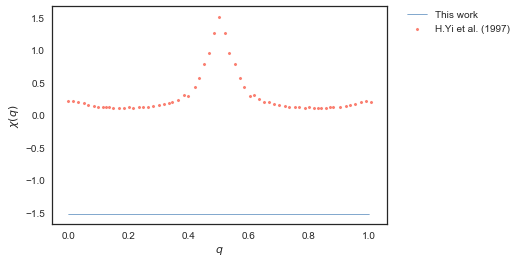

In [125]:
chi_compare = np.loadtxt("../data/Yi1997/chi_compare.csv")
fig = plt.figure(0)
ax = fig.add_subplot(111)
plt.xlabel(r'$q$')
plt.ylabel(r'$\chi(q)$')
ax.scatter(chi_compare[:, 0], chi_compare[:, 1], s = 4, color = 'salmon', marker = 'x', label = 'H.Yi et al. (1997)')
ax.plot(qs/2/np.pi, MagSus, linewidth = 0.5, label = 'This work')
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
if SAVEPLOTS == True:
    plt.savefig(plotDir + '/chi_compare.png', dpi = 600)

# Again, it has a maximum at $q = \pi$ signaling quasi-AF order

In [129]:
threshold =30
qs[np.argmax(MagSus[threshold:n_qs-threshold]) + threshold]

0.37699111843077521